# Strategies for Analyzing a 12-Gigabyte Data Set: Airline Flight Delays - Case Study Unit 14


#### Cory Adams, Chris Boomhower, Alexandra Fisher, Alex Frye
#### MSDS 7333, December 10, 2017

## Abstract
This case study was undertaken in order to investigate and highlight how to work with datasets that are too large in size to fit into local memory. To do this, 12 gigabytes of historical flight data for on-time performance is selected and the data is loaded and analyzed out-of-core using a branch processing method [2]. For purposes of this study, the split-apply-combine approach is used and both of the R and Python languages are leveraged to manage the data out-of-core. Results are then used to ultimately determine if consumers can reduce the number of flight delays experienced by answering key questions, such as which airports and flights are most likely to be delayed. Findings indicate that ATL, DEN, DFW, EWR, LAX, ORD, and PHX are the top seven airports most likely to be delayed flying out of or into, which makes sense because all are located in cities serving as hubs for major airlines. Of these seven, flights with ORD and ATL as either the destination or departure airport have the highest arrival delay, respectively. To that end, flights with ORD as the origin and EWR as the destination are the most likely to be delayed. Finally, in modeling the airline data set we find that indeed we can regress how delayed a flight will be before it is delayed by [insert how] with the most important features for this regression being [insert key features].  


## Introduction
In this case study, the objective is not only to investigate how to work with oversized data sets too massive for local memory, but to answer key questions pertaining to airline flight performance. Specifically, a key measurement of success in the airline industry is on-time performance, which is an indicator of flight delays. The following questions of interest will be answered in this study:

1.	Which airports are most likely to be delayed flying out of or into?
2.	Which flights with same origin and destination are most likely to be delayed? 
3.	Can we regress how delayed a flight will be before it is delayed? What are the most important features for this regression? 

In answering these key questions, this study will aid in determining if consumers can reduce the quantity of flight delays experienced via analyzing historical flight data collected between 1987 and 2009 [2]. The airline data set used can be found at http://stat-computing.org/dataexpo/2009/the-data.html.

To best handle loading and analyzing the large airline dataset, the data must be processed out-of-core via a branch processing method. In particular, the split-apply-combine technique is utilized with various APIs. For the purpose of this study, R and Python languages are leveraged to manage the data out-of-core. 


## Background
The “Airline on-time performance” data set [2] comes from the American Statistical Association (ASA) Section on Statistical Computing and Statistical Graphics released in 2009 “for their biannual data exposition” [1]. The data set was compiled and released from the U.S. Government’s Bureau of Transportation Research and Innovative Technology Administration (RITA) and includes flight information from October 1987 to April 2008 for over 120 million flights. Flight data includes a total of 29 variables for each flight, such as flight time, delay time, departure airport, and arrival airport, equaling a total of 12 gigabytes in files. 

In particular, a researcher from Yale University named Michael Kane strategizes how to analyze massive datasets using the “Airline on-time performance” data set. Kane provides a case study that explains how to acquire the data set, explore the data set using different environments such as R, Unix, and SQL db and parallel computing, and model the airline data set [3 & 4]. 

## Methods
The steps used for this analysis were: 1) data acquisition and decompression, 2) loading data into memory using both R and Python to verify decompression, 3) preprocessing data in chunks, and 4) data analysis out-of-core using Python. 

Note that code used includes modified versions of R code function examples found in Data Science in R: A Case Studies Approach to Computational Reasoning and Problem Solving, Chapter 5, pages 217-236 [1].

## Results

### Batch Processing in R and Python
This notebook is built off of chapter five in the text "Data Science in R", http://www.amazon.com/Data-Science-Approach-Computational-Reasoning/dp/1482234815.

___
### Downloading the dataset (using python)
Descriptions of the data files may be located here: http://stat-computing.org/dataexpo/2009/the-data.html.
In the following blocks of code, we download the data and then decompress the files into .csv files. Each csv contains data for one year of airline flights. 


In [1]:
import os, sys
import pandas as pd
import numpy as np
import sys
import time
import cPickle as pickle
from matplotlib import pyplot as plt
from math import floor
import seaborn as sns

#Here I needed to register (https://turi.com/register) and upgrade my graphlab using a free, academic-use-only product key:
# pip install --upgrade --trusted-host pypi.python.org graphlab-create 
# pip install --upgrade --no-cache-dir https://get.graphlab.com/GraphLab-Create/2.1/your registered email address here/your product key here/GraphLab-Create-License.tar.gz
import graphlab as gl
#gl.get_dependencies() #Just need to run this the first time if graphlab loads but a dependcy error ACTION REQUIRED note appears

import graphlab.aggregate as agg

from IPython.display import display
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

%matplotlib inline

# create a Data directory if not done already
path = "Airline/"
if not os.path.exists(path):
    os.mkdir( path, 0755 )
print(path)

Airline/


In [2]:
import urllib # this is part of the standard library for python
import bz2 # this is also part of the python standard library
#from urllib.request import urlretrieve
i = 0
for dirpath, dirnames, files in os.walk(path):
    if files and i==0:
        print("Files already downloaded and decompressed")
    if not files and i==0:
        years_to_download = range(1987,2009) # get the years 1987 through 2008
        baseurl = 'http://stat-computing.org/dataexpo/2009/%d.csv.bz2' 

        files = []
        for year in years_to_download:
            # prepare strings
            url_of_data_file = baseurl%(year) # get the URL for the data file
            save_as_filename = path + '%d.csv.bz2'%(year) 
            # save as this
            files += [save_as_filename] # save name of the compressed file

            # download file
            print('Downloading %s to %s' % (url_of_data_file, save_as_filename)) # progress update
            urllib.urlretrieve(url_of_data_file, save_as_filename) #execute download
            
        # Now lets decompress all the files
        for filename in files:#[path+'2006.csv.bz2',path+'2007.csv.bz2',path+'2008.csv.bz2']:
            # get file names
            filepath = filename
            newfilepath = filename[:-4]
            print('Decompressing', filepath,'to', newfilepath)

            # go through the decompressed chunks and write out to a decompressed file
            with open(newfilepath, 'wb') as new_file, bz2.BZ2File(filepath, 'rb') as file:
                for data in iter(lambda : file.read(100 * 1024), b''):
                    new_file.write(data)
    i = i+1

Files already downloaded and decompressed


### Loading data into memory
Utilizing GraphLab's read_csv function, we iterate through each csv file and process data into an sframe.

In [3]:
if not os.path.exists(path+'airline_data_sframe_directory'):
    os.mkdir(path+'airline_data_sframe_directory', 0755)
    print('airline_data_sframe_directory directory created')
    
for dirpath, dirnames, files in os.walk(path+'airline_data_sframe_directory'):
    if files:
        print("Binary compressed files already exist")
        sf = gl.load_sframe(path+'airline_data_sframe_directory')
    if not files:
        # What about just loading up all the data using the SFrame Utility for loading CSV files?
        # We will need to make sure that the SFrame has consistent datatypes, so we will give the value for each header
        column_hints=[int,int,int,int,int,int,int,int,str,int,str,int,int,int,int,int,str,str,int,int,int,int,str,int,int,int,int,int,int]

        t = time.time()
        # now load the first SFrame
        sf = gl.SFrame() #.read_csv('Data/1987.csv',column_type_hints=column_hints)

        # and then append each SFrame in a for loop
        for year in range(1987,2009):
            print 'read %d lines, reading next file %d.csv'%(sf.shape[0],year)
            sys.stdout.flush()
            sftmp = gl.SFrame.read_csv('Airline/%d.csv'%(year),column_type_hints=column_hints)
            sf = sf.append(sftmp)

        print 'It took %.2f seconds to concatenate the memory mapped file'%(time.time()-t)

        t = time.time()
        print 'Saving...',
        sf.save(path+'airline_data_sframe_directory') # save a compressed version of this SFrame
        print 'took %.2f seconds'%(time.time()-t),'Shape of SFrame is',sf.shape

Binary compressed files already exist
This non-commercial license of GraphLab Create for academic use is assigned to amfrye@smu.edu and will expire on December 10, 2018.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: C:\Users\alexf\AppData\Local\Temp\graphlab_server_1513055419.log.0


### Analysis using GraphLab Dataset
#### Which airports are most likely to be delayed flying out of or into?

The top seven airports to be delayed overall, whether flying into or flying out of are: 
1. Hartsfield-Jackson Atlanta International Airport (ATL)
2. Denver International Airport (DEN)
3. Dallas/Fort Worth International Airport (DFW)
4. Newark Liberty International Airport (EWR)
5. Las Angeles International Airport (LAX)
6. Chicago O'Hare International Airport (ORD)
7. Phoenix Sky Harbor International Airport (PHX)

This makes sense since all seven are located in cities with a large population and all serve as hubs for major airlines. The two bar charts we will show below look similar as there is clearly a correlation between arrival and departure delays. Regardless of whether the origin or destination caused a delay, the opposite will likely be true as a result. Also, this project uses total data not ratios, which again makes these airports likely candidates to have the highest number of delays based on the amount of traffic.

In [4]:
##get total SUM across all years, identify top 5 list
%time origin_Delays = sf.groupby(key_columns='Origin', operations={'SUM_origin_ArrDelay': agg.SUM("ArrDelay"),'SUM_origin_DepDelay': agg.SUM("DepDelay")}).sort('SUM_origin_ArrDelay',ascending = False).to_dataframe()
#display(origin_Delays.head())

Top5OriginByArrivalDelay = np.array(origin_Delays["Origin"].head())
#print Top5OriginByArrivalDelay

Top5OriginByDepDelay = np.array(origin_Delays.sort_values("SUM_origin_DepDelay",ascending = False)["Origin"].head())
#print Top5OriginByDepDelay

#Concatenate Top 5 Arrival and Delay Origins for Consistent Plotting
TopOrigin = np.unique(np.concatenate((Top5OriginByArrivalDelay,Top5OriginByDepDelay), axis=0))
print "The Top Origins across both Arrival and Departure Delays: " 
print TopOrigin



##break down by Origin by year for the identified "TopOrigin" Origins
%time origin_DelaysByYear = sf.groupby(key_columns=['Year','Origin'], operations={'SUM_origin_ArrDelay': agg.SUM("ArrDelay"),'SUM_origin_DepDelay': agg.SUM("DepDelay")}).sort('SUM_origin_ArrDelay',ascending = False).to_dataframe()
Short_origin_DelaysByYear = origin_DelaysByYear[(origin_DelaysByYear["Year"]>2002) & (origin_DelaysByYear["Origin"].isin(TopOrigin))]
#display(Short_origin_DelaysByYear)


Wall time: 28.6 s
The Top Origins across both Arrival and Departure Delays: 
['ATL' 'DEN' 'DFW' 'EWR' 'LAX' 'ORD' 'PHX']
Wall time: 21 s


The bar chart below shows the top seven airports listed above as the destination (flying into) and the total number of minutes the arrival was delayed by year. This chart shows the data for the years 2003 to 2008. Chicago O'Hare and Hartsfield-Jackson Atlanta have the highest arrival delay consistently over this time period. The gap between these two airports and the next highest (Dallas/Fort Worth) is significant. There are a couple of things worth noting in this bar chart. The first is the number arrival delays at all seven airports have decreased over time. This could be due to several events, for example scheduling has improved. The second interesting fact is 2007 was a poor year for all of the airports. It seems this was due to a combination of factors: such increased demand during peak hours, increased demand in general, and a higher than normal air traffic control turnover.

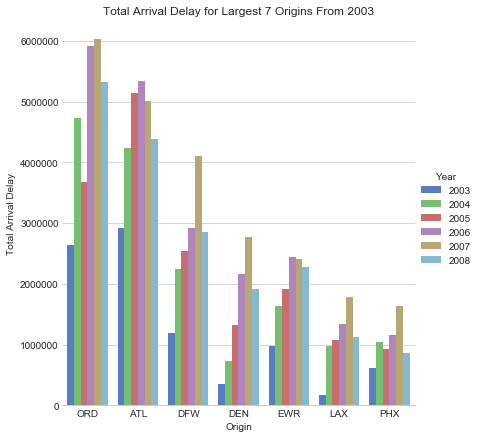

In [5]:
sns.set_style("whitegrid")
g = sns.factorplot(x="Origin", y="SUM_origin_ArrDelay", hue="Year", data=Short_origin_DelaysByYear,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Total Arrival Delay")

titles = ["Total Arrival Delay for Largest 7 Origins From 2003"]
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)
g


The bar chart below shows the top seven airports listed above as the origin (flying out of) and the total number of minutes the departure was delayed by year. This chart shows the data for the years 2003 to 2008. There is not much to interpret beyond what we discussed above. The ordering of the airports with highest departure delay total is the same as the ordering of airports with the highest arrival delay total. Again, there is likely a high correlation between the two events and the factors that led to them.

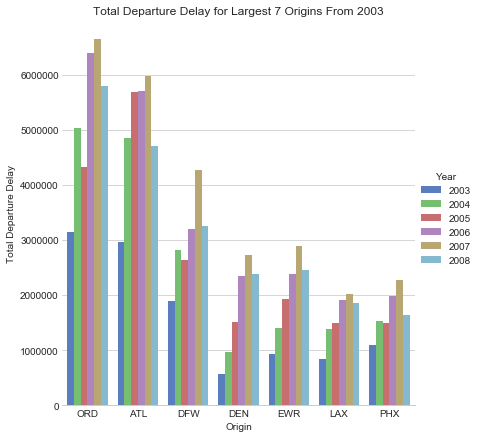

In [6]:
g = sns.factorplot(x="Origin", y="SUM_origin_DepDelay", hue="Year", data=Short_origin_DelaysByYear,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Total Departure Delay")

titles = ["Total Departure Delay for Largest 7 Origins From 2003"]
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)
g

#### Which flights with same origin and destination are most likely to be delayed?

The bar chart below shows combinations of origin and destination and their largest arrival delays in minutes for 2007 and 2008. We use one origin, Chicago O'Hare International Airport, as it had the highest origin delay totals for both years. We then determined the top five largest destination arrival delays associated with Chicago O'Hare as the origin. These top five combinations are (origin -> destination):

1. Chicago O'Hare International Airport (ORD) -> Newark Liberty International Airport (EWR)
2. ORD -> LaGuardia Airport (LGA)
3. ORD -> Dallas/Fort Worth International Airport (DFW)
4. ORD -> Minneapolis-Saint Paul International Airport (MSP)
5. ORD -> Philadelphia International Airport (PHL)


In [7]:
##Identity top 5 Destinations for the "ORD" Origin
%time Arrorigin_TopDest_Delays = sf[(sf["Year"]>2006) & (sf["Origin"]=="ORD")].groupby(key_columns=['Origin','Dest'], operations={'SUM_origin_ArrDelay': agg.SUM("ArrDelay"),'SUM_origin_DepDelay': agg.SUM("DepDelay"),'COUNT': agg.COUNT()}).sort('SUM_origin_ArrDelay',ascending = False).to_dataframe()
#display(Arrorigin_TopDest_Delays)

##identify top 5 list per "Dest" by arrival time
ArrTopDest = np.array(Arrorigin_TopDest_Delays["Dest"].head())
print ArrTopDest

##get totals across all years ordered by departure time, filtered by top dest
%time Arrorigin_dest_Delays = sf[(sf["Year"]>2006) & (sf["Origin"]=="ORD")].filter_by(ArrTopDest, 'Dest').groupby(key_columns=['Origin','Dest','FlightNum'], operations={'SUM_origin_ArrDelay': agg.SUM("ArrDelay"),'SUM_origin_DepDelay': agg.SUM("DepDelay"),'COUNT': agg.COUNT()}).sort('SUM_origin_ArrDelay',ascending = False).to_dataframe()
#display(Arrorigin_dest_Delays.head())

##identify top 2 list per "group" by arrival time
ArrTopPerGroup = Arrorigin_dest_Delays.groupby(['Origin','Dest']).head(2).sort_values(['Origin','Dest']).reset_index(drop=True)
#display(ArrTopPerGroup)

TopFlightByArrivalDelay = np.array(ArrTopPerGroup["FlightNum"])
#print TopFlightByArrivalDelay

##break arr down by year
%time Arrorigin_dest_DelaysByYear = sf[(sf["Year"]>2006) & (sf["Origin"]=="ORD")].filter_by(ArrTopDest, 'Dest').filter_by(TopFlightByArrivalDelay, 'FlightNum').groupby(key_columns=['Year','Origin', 'Dest', 'FlightNum'], operations={'SUM_origin_ArrDelay': agg.SUM("ArrDelay"),'SUM_origin_DepDelay': agg.SUM("DepDelay"),'COUNT': agg.COUNT()}).sort('SUM_origin_ArrDelay',ascending = False).to_dataframe()
Arrorigin_dest_DelaysByYear["Origin_Dest_FlightNum"] = Arrorigin_dest_DelaysByYear["Origin"] + " / " + Arrorigin_dest_DelaysByYear["Dest"] + " / " + Arrorigin_dest_DelaysByYear["FlightNum"].map(str)
#display(Arrorigin_dest_DelaysByYear)


Wall time: 28.1 s
['LGA' 'EWR' 'MSP' 'DFW' 'PHL']
Wall time: 1min 6s
Wall time: 56.4 s


Now that we have determined the airport combinations, we queried the two largest arrival delays for each across 2007 and 2008 using the same flight number. While this chart will not provide conclusive evidence about whether these combinations/flights are outliers or they represent the data. What can understand from looking at this chart is there appears to be significant delays between ORD and EWR, as well as, ORD and LGA. Since there are no significant differences between 2007 and 2008, we can view this as being a consistent problem (delay) and likely not outliers. Also, it is interesting that the top 2 destinations, EWR and LGA, are located about 40 miles apart in a high traffic area.

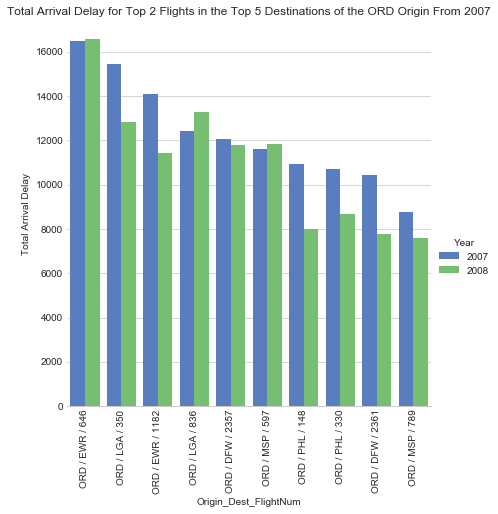

In [8]:
sns.set_style("whitegrid")
g = sns.factorplot(x="Origin_Dest_FlightNum", y="SUM_origin_ArrDelay", hue="Year", data=Arrorigin_dest_DelaysByYear,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Total Arrival Delay")
#g.title("Total Arrival Delay for Top 2 Flights in the Top 5 Destinations of the ORD Origin From 2007")
g.set_xticklabels(rotation=90)

titles = ["Total Arrival Delay for Top 2 Flights in the Top 5 Destinations of the ORD Origin From 2007"]
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)



The bar chart below shows combinations of origin and destination and their largest departure delays in minutes for 2007 and 2008. We use one origin, Chicago O'Hare International Airport, as it had the highest departure delay totals for both years. We then determined the top five largest destination delays associated with Chicago O'Hare as the origin. These top five combinations are (origin -> destination):

1. Chicago O'Hare International Airport (ORD) -> Newark Liberty International Airport (EWR)
2. ORD -> LaGuardia Airport (LGA)
3. ORD -> Dallas/Fort Worth International Airport (DFW)
4. ORD -> Las Angeles International Airport (LAX)
5. ORD -> Minneapolis-Saint Paul International Airport (MSP)

In [9]:
##Identity top 5 Destinations for the "ORD" Origin
%time Deporigin_TopDest_Delays = sf[(sf["Year"]>2006) & (sf["Origin"]=="ORD")].groupby(key_columns=['Origin','Dest'], operations={'SUM_origin_ArrDelay': agg.SUM("ArrDelay"),'SUM_origin_DepDelay': agg.SUM("DepDelay"),'COUNT': agg.COUNT()}).sort('SUM_origin_DepDelay',ascending = False).to_dataframe()
#display(Deporigin_TopDest_Delays)

##identify top 5 list per "Dest" by arrival time
DepTopDest = np.array(Deporigin_TopDest_Delays["Dest"].head())
print DepTopDest

##get totals across all years ordered by departure time, filtered by top dest
%time Deporigin_dest_Delays = sf[(sf["Year"]>2006) & (sf["Origin"]=="ORD")].filter_by(DepTopDest, 'Dest').groupby(key_columns=['Origin','Dest','FlightNum'], operations={'SUM_origin_ArrDelay': agg.SUM("ArrDelay"),'SUM_origin_DepDelay': agg.SUM("DepDelay"),'COUNT': agg.COUNT()}).sort('SUM_origin_DepDelay',ascending = False).to_dataframe()
#display(Deporigin_dest_Delays.head())

##identify top 2 list per "group" by arrival time
DepTopPerGroup = Deporigin_dest_Delays.groupby(['Origin','Dest']).head(2).sort_values(['Origin','Dest']).reset_index(drop=True)
#display(DepTopPerGroup)

TopFlightByDepartureDelay = np.array(DepTopPerGroup["FlightNum"])
#print TopFlightByDepartureDelay

##break arr down by year
%time Deporigin_dest_DelaysByYear = sf[(sf["Year"]>2006) & (sf["Origin"]=="ORD")].filter_by(DepTopDest, 'Dest').filter_by(TopFlightByDepartureDelay, 'FlightNum').groupby(key_columns=['Year','Origin', 'Dest', 'FlightNum'], operations={'SUM_origin_ArrDelay': agg.SUM("ArrDelay"),'SUM_origin_DepDelay': agg.SUM("DepDelay"),'COUNT': agg.COUNT()}).sort('SUM_origin_DepDelay',ascending = False).to_dataframe()
Deporigin_dest_DelaysByYear["Origin_Dest_FlightNum"] = Deporigin_dest_DelaysByYear["Origin"] + " / " + Deporigin_dest_DelaysByYear["Dest"] + " / " + Deporigin_dest_DelaysByYear["FlightNum"].map(str)
#display(Deporigin_dest_DelaysByYear)


Wall time: 25 s
['LGA' 'EWR' 'MSP' 'DFW' 'LAX']
Wall time: 57.1 s
Wall time: 55.5 s


Now that we have determined the airport combinations, we queried the two largest delays for each across 2007 and 2008 using the same flight number. The departure delay combinations have four of the same five combinations as arrival delays, with the only difference being LAX instead of PHL. Again, the top two delay combinations are ORD to EWR and ORD to LGA. However, the flight numbers of the top combinations are slightly different. Flight 646 from ORD to still appears to be the worst flight ever. It makes sense that if arrival delays exist at an airport, they could have a direct impact on the departure delays at another. As the same combinations appear on top, we can assume it is hard to directly attribute arrival vs. departure delay issues as much as we can just understand there is a correlation between the pairs.

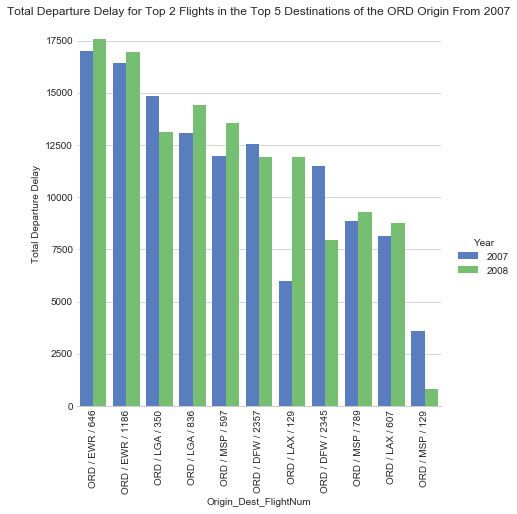

In [10]:
g = sns.factorplot(x="Origin_Dest_FlightNum", y="SUM_origin_DepDelay", hue="Year", data=Deporigin_dest_DelaysByYear,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Total Departure Delay")
g.set_xticklabels(rotation=90)
titles = ["Total Departure Delay for Top 2 Flights in the Top 5 Destinations of the ORD Origin From 2007"]
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)
g

#### Can we regress how delayed a flight will be before it is delayed? What are the most important features for this regression?

The code below creates the ArrTimeByHour and DepTimeByHour variables, to reduce the inaccurate numerical scaling of the HH:MM ArrTimeByHour and DepTimeByHour features.

In [11]:
sf['DepTimeByHour'] = sf['CRSDepTime'].apply(lambda x: floor(x/100),dtype=int)
sf['DepTimeByHour'] = sf['DepTimeByHour'].apply(lambda x: 0 if x==24 else x)

sf['ArrTimeByHour'] = sf['CRSArrTime'].apply(lambda x: floor(x/100),dtype=int)
sf['ArrTimeByHour'] = sf['ArrTimeByHour'].apply(lambda x: 0 if x==24 else x)


The code below removes the target variables and overlapping attributes. The code then checks if compressed binaries have been saved to disk, if not we sample 10% of the data for performance (run time). Using either the complete data from the compressed binaries or the 10% sample, we then generate 10-folds for 10-fold cross validation. Cross validation allows us to sample the data 10 times, each sample having a new training and test dataset. This allows us to evaluate the majority of the data and ensure our results are stable.

In [12]:
%%time
seed = 10
cols = ['Month',
       'DayofMonth',
       'DayOfWeek',
       'UniqueCarrier',
       'ActualElapsedTime',
       'AirTime',
       'ArrDelay',
       'DepDelay',
       'Origin',
       'Dest',
       'Distance',
       'TaxiIn',
       'TaxiOut',
       'Diverted',
       'DepTimeByHour',
       'ArrTimeByHour']

feats = cols[:]
feats.remove('ArrDelay')
feats.remove('DepDelay')

if not os.path.exists(path+'sf_samp_directory'):
    os.mkdir(path+'sf_samp_directory', 0755)

for dirpath, dirnames, files in os.walk(path+'sf_samp_directory'):
    if files:
        print("sf_samp binary compressed files already exist")
        sf_samp = gl.load_sframe(path+'sf_samp_directory')
    if not files:
        sf_samp = sf.sample(0.1, seed=seed)
        sf_samp = sf_samp[cols].dropna()
        sf_samp.save(path+'sf_samp_directory')
        
folds = gl.cross_validation.KFold(sf_samp, 10)

sf_samp binary compressed files already exist
Wall time: 10 ms


For each of the 10 folds we just created, a model is developed and stored as a binary for performance of future execution and the ability to easily reproduce results. The code segment above checked for the binaries, but ran a sample if they were not present. Similarly, the following code segment checks if binaries exist and save the model of each fold if they do not.

In [13]:
%%time

if not os.path.exists(path+'mList_directory'+'0'):
    for i in range(10):
        os.mkdir(path+'mList_directory'+str(i), 0755)

mList=[]
for dirpath, dirnames, files in os.walk(path+'mList_directory'+'0'):
    if files:
        print("mList binary compressed files already exist")
        for i in range(10):
            mList.append(gl.load_model(path+'mList_directory'+str(i)))
    if not files:
        for i, (train, valid) in enumerate(folds):
            m = gl.random_forest_regression.create(train, target='ArrDelay', features=feats, random_seed=seed)
            print m.evaluate(valid)
            mList.append(m)
            m.save(path+'mList_directory'+str(i)) # write out as binary compressed file (very compressed)
        print("mList binary compressed files created")

# WE WERE HAVING ISSUES GETTING CROSS_VAL_SCORE TO WORK WITH DESIRED EVALUATION METRICS, SO COMPUTED MANUALLY INSTEAD IN NEXT CHUNK
#def custom_evaluator(model, train, test):
#    RMSE = model['validation_rmse']
#    ME = model['validation_max_error']
#    return {'validation_rmse': RMSE, 'validation_max_error': ME}
#    
#params = dict([('target', 'ArrDelay'), ('features', feats)])
#job = gl.cross_validation.cross_val_score(folds,
#                                          gl.boosted_trees_classifier.create,
#                                          params, evaluator = custom_evaluator)
#print job.get_results()

mList binary compressed files already exist
Wall time: 45 ms


Each of the 10 models we created using 10-fold cross validation is evaluated to determine the Root-mean-square Error (RMSE) and Max Error values. The goal is to identify if consistency exists across the folds, which would prove robustness in the model across the 10 datasets. The mean for both RMSE and Max Error are shown below. The grid below show us each plot for the 10 folds and a regression line. We can see there is a bit of variance between the folds, with the lowest max error value below 1200 and the highest above 1700. However, the RMSE was relatively close between 30.2 and 31.6 across all 10 folds.

Mean RMSE = 30.9672222137
Mean Max Error = 1380.37089844


Text(0.5,1,u'10-Fold Max Errors With Respect to RMSE Values')

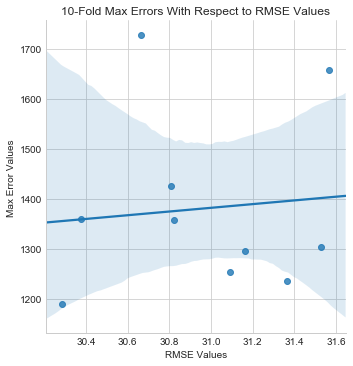

In [14]:
def mean(x):
    return float(sum(x)) / len(x)

m_rmse=[]
m_ME=[]

for m in mList:
    m_rmse.append(m.validation_rmse)
    m_ME.append(m.validation_max_error)
    
evals = pd.DataFrame({'RMSE Values':m_rmse, 'Max Error Values':m_ME})

print('Mean RMSE = ' + str(mean(m_rmse)))
print('Mean Max Error = ' + str(mean(m_ME)))

sns.lmplot(x='RMSE Values',y='Max Error Values',data=evals,fit_reg=True,)
plt.title('10-Fold Max Errors With Respect to RMSE Values')

Finally, we present the feature importance counts for the random forest model generated on the entire sampled dataset. The measure of importance of each feature is determined by the sum of occurrence of the feature as a branching node in all trees. The output below shows our top features as: TaxiOut, TaxiIn, ActualElapsedTime, and DepTimeByHour. By looking at these features we can start to understand why they would be of high importance to the model. TaxiOut and TaxiIn likely account for the majority of the delays, as flights are either waiting to takeoff or waiting for a gate. The DepTimeByHour seems to be important as peak travel times often lead to delays.

In [15]:
%%capture 
m2 = gl.random_forest_regression.create(sf_samp, target='ArrDelay', features=feats, random_seed=seed)

In [16]:
m2.get_feature_importance().print_rows(num_rows = 30)

+-------------------+-------+-------+
|        name       | index | count |
+-------------------+-------+-------+
|       TaxiIn      |  None |  180  |
|      TaxiOut      |  None |  137  |
|   DepTimeByHour   |  None |   71  |
| ActualElapsedTime |  None |   60  |
|      Distance     |  None |   33  |
|      AirTime      |  None |   25  |
|       Origin      |  EWR  |   20  |
|       Origin      |  JFK  |   18  |
|   ArrTimeByHour   |  None |   17  |
|       Month       |  None |   12  |
|   UniqueCarrier   |   B6  |   5   |
|        Dest       |  PHX  |   4   |
|   UniqueCarrier   |   CO  |   4   |
|     DayOfWeek     |  None |   3   |
|   UniqueCarrier   |   WN  |   3   |
|        Dest       |  SFO  |   2   |
|       Origin      |  ORD  |   2   |
|        Dest       |  EWR  |   2   |
|       Origin      |  LGA  |   2   |
|       Origin      |  SDF  |   2   |
|   UniqueCarrier   |   TZ  |   2   |
|       Origin      |  MCN  |   2   |
|   UniqueCarrier   |   OH  |   2   |
|        Des

## Conclusion and Future Works
Ultimately the airports most likely to be delayed flying into or out of are located in the major cities of Atlanta (ATL), Denver (DEN), Dallas/Fort Worth (DFW), Newark (EWR), Los Angeles (LAX), Chicago (ORD), and Phoenix (PHX). Also, flights with Chicago (ORD) as the origin and Newark (EWR) as the destination are the most likely to be delayed. In modeling the airline data set we found that we can regress how delayed a flight will be before it is delayed by generating a random forest model with the most important features for this regression being TaxiIn, TaxiOut, ActualElapsedTime, DepTimeByHour, Distance, Origin, and ArrTimeByHour.

Overall, the split-apply-combine technique was found to be effective in loading and analyzing the 12 gigabytes of airline flight data. By using this technique, we were able to process over 120 million records using the local memory in our individual household computers. In addition, the GraphLab package utilized in Python proved easiest to handle with higher performance than R, saving significant time as well since preprocessing is not required. As an extension of our efforts, future works would include parameter tuning the random forest model inputs; testing other model types (e.g. boosted tree regression, linear regression) using GraphLab; and scaling features to normalize values. 

## References
[1] D. Lang and D. Nolan, Data Science in R: A Case Studies Approach to Computation Reasoning and Problem Solving. New York, New York: CRC Press.

[2] H. Wickham. Airline on-time performance Web page. http://statcomputing.org/dataexpo/2009/, 2009.

[3]  M. Kane and J. Emerson. biganalytics : A library of utilities for big.matrix objects of package bigmemory. http://cran.r-project.org/package=biganalytics , 2010. R package version 1.0.14.

[4]  M. Kane and J. Emerson. bigmemory : Manage massive matrices with shared memory and memory-mapped files. http://cran.r-project.org/package=bigmemory , 2011. R package version 4.2.11.
